In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
from functools import reduce
import matplotlib.image as mpimg
import glob
from google.colab import drive
from tqdm import tqdm 
import matplotlib.pyplot as plt
import os
os.environ['CUDA_LAUNCH_BLOCKING']='1'

drive.mount('/content/gdrive/')
print(torch.__version__)

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
1.11.0+cu113


# Declare data information and hyperparameters

In [ ]:
# Data information
dataset_name = 'airplane32' # Dataset name
image_size = (32, 32) # Size of real image
# dataset_name = 'airplane64' # Dataset name
# image_size = (64, 64) # Size of real image

# Hyperparameters
n_epoch = 50 # Number of epochs
batch_size = 64 # Batch size
z_size = 201 # Number of dimensions of the generator input z
init_channel_size = 256 # Initial channel size
voxel_scale = 2 # The scaling facor of voxels
d_margin = 0.75 # The max accuracy of the discriminator that it can be trained

# Structures of the generator and the discriminator

In [ ]:
# Initialize the weights and biases of corresponding network layers
# m: The neural network to be initialized
def layer_init(m):
  classname = m.__class__.__name__
  if classname.find('Linear') != -1:
    nn.init.normal_(m.weight.data, mean=0.0, std=0.1)
    nn.init.constant_(m.bias.data, 0)
  # both ConvTranspose3d and Conv2d have same initial weight and bias
  elif classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, mean=0.0, std=0.02)
    nn.init.constant_(m.bias.data, 0)

# Tensorflow data shape: NDHWC
# Pytorch data shape: NCDHW
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    init_channel_size
    
    # for voxel shape of 32x32x32
    self.layer0a = nn.Sequential(
      nn.Linear(in_features=z_size-1, out_features=4*4*4*init_channel_size, bias=True)
    )
    # # for voxel shape of 64x64x64
    # self.layer0a = nn.Sequential(
    #   nn.Linear(in_features=z_size-1, out_features=8*8*8*init_channel_size, bias=True)
    # )


    self.layer0b = nn.Sequential(
      nn.BatchNorm3d(num_features=init_channel_size, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None),
      nn.ReLU()
    )

    self.layer1 = nn.Sequential(
      nn.ConvTranspose3d(in_channels=init_channel_size, out_channels=init_channel_size//2, kernel_size=5, stride=2, padding=2, output_padding=1, groups=1, bias=True, dilation=1, padding_mode='zeros', device=None, dtype=None),
      nn.BatchNorm3d(num_features=init_channel_size//2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None),
      nn.ReLU()
    )

    self.layer2 = nn.Sequential(
      nn.ConvTranspose3d(in_channels=init_channel_size//2, out_channels=init_channel_size//4, kernel_size=5, stride=2, padding=2, output_padding=1, groups=1, bias=True, dilation=1, padding_mode='zeros', device=None, dtype=None),
      nn.BatchNorm3d(num_features=init_channel_size//4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None),
      nn.ReLU()
    )

    self.layer3 = nn.Sequential(
      nn.ConvTranspose3d(in_channels=init_channel_size//4, out_channels=1, kernel_size=5, stride=2, padding=2, output_padding=1, groups=1, bias=True, dilation=1, padding_mode='zeros', device=None, dtype=None),
      nn.Sigmoid()
    )
    
  def forward(self, z_enc):
    x = self.layer0a(z_enc[:, :-1])
    x = torch.reshape(x, [batch_size, init_channel_size, 4, 4, 4])
    # x = torch.reshape(x, [batch_size, init_channel_size, 8, 8, 8])
    x = self.layer0b(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x) * voxel_scale
    voxels = torch.reshape(x, [batch_size, 32, 32, 32])
    # voxels = torch.reshape(x, [batch_size, 64, 64, 64])
    return voxels

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.layer0 = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=256, kernel_size=5, stride=2, padding=2, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None),
      nn.BatchNorm2d(num_features=256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None),
      nn.LeakyReLU(negative_slope=0.2)
    )
    self.layer1 = nn.Sequential(
      nn.Conv2d(in_channels=256, out_channels=512, kernel_size=5, stride=2, padding=2, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None),
      nn.BatchNorm2d(num_features=512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None),
      nn.LeakyReLU(negative_slope=0.2)
    )
    self.layer2 = nn.Sequential(
      nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=5, stride=2, padding=2, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None),
      nn.BatchNorm2d(num_features=1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None),
      nn.LeakyReLU(negative_slope=0.2)
    )
    # for image size of 32x32
    self.layer3a = nn.Linear(in_features=16*32*32, out_features=1, bias=True)
    # # for image size of 64x64
    # self.layer3a = nn.Linear(in_features=16*64*64, out_features=1, bias=True)
    self.layer3b = nn.Sigmoid()
    
  
  def forward(self, image):
    reshaped_image = torch.reshape(image, [batch_size, 1, image_size[0], image_size[1]])
    x0 = self.layer0(reshaped_image)
    x = self.layer1(x0)
    x = self.layer2(x)
    x = torch.reshape(x, [batch_size, -1])
    x3a = self.layer3a(x)
    x3b = self.layer3b(x3a)
    return (x3b, x3a, x0)

# Save fake images and generated voxels

In [ ]:
# Create 'path' if it does not exist
def create_folder(path):
  if os.path.exists(path):
    return
  else:
    print("Folder {} not found. Creating one...".format(path))
    os.makedirs(path)
    print("Done.")

# Save 'images' as the subplots of a bigger figure
# size: The layout of subplots is size[0] * size[1]
# path: the filename of the saving figure
def save_images(images, size, path):
  images = np.clip(images, 0, 1)

  h, w = images.shape[1], images.shape[2]
  figure = np.zeros((h * size[0], w * size[1], 3))

  for idx, image in enumerate(images):
    i = idx // size[1]
    j = idx % size[1]
    figure[i*h:i*h+h, j*w:j*w+w, :] = image

  return mpimg.imsave(path, figure)

# Save separate 'voxels' in 'folder'
def save_voxels(voxels, folder):
  basename="/volume{}.npy"
  for i in range(voxels.shape[0]):
    np.save(folder+basename.format(i), voxels[i, :, :, :])

def save_separate_images(images, folder):
  basename = "/image{}.png"
  for i in range(images.shape[0]):
    mpimg.imsave(folder+basename.format(i), images[i, :, :, 0], cmap='gray')

# Projection Module

In [ ]:
# Render the generated 3D shape from a randomly-chosen viewpoint
# v: The last dimension of generator inputs, z_enc[:, 200]
# voxels: The generated 3D shape
def projection(v, voxels):
  rendered_imgs = []
  for i in range(batch_size):
    img = project(transform_volume(voxels[i], rot_matrix(v[i])))
    rendered_imgs.append(img)

  final_imgs = torch.reshape(torch.stack(rendered_imgs), [batch_size, image_size[0], image_size[1], 1])
  return final_imgs

# Compute the rotation matrix according to the viewpoint
# s: The last dimension of a Generator input
def rot_matrix(s):
  # Pre-selected viewpoints which are evenly spaced around the y-axis
  hp = torch.Tensor([0, 0, 0, 0, 0, 0, 0, 0]).to(device)
  vp = torch.Tensor([0, np.pi/4.0, np.pi/2.0, 3*np.pi/4.0, np.pi, 5*np.pi/4.0, 3*np.pi/2.0, 7*np.pi/4.0]).to(device)

  # Scale s from [-1, 1] to [0, 8]
  i = ((s + 1) * 4).type(torch.int64).to(device)
  if i == 8: i = 7

  # Use i as an index and get the corresponding viewpoint
  theta = torch.gather(hp, 0, i).to(device)
  phi = torch.gather(vp, 0, i).to(device)

  sin_theta = torch.sin(theta)
  cos_theta = torch.cos(theta)
  sin_phi = torch.sin(phi)
  cos_phi = torch.cos(phi)

  # Rotation matrix of rotating around x-axis
  rx = torch.Tensor([[1, 0, 0], [0, cos_theta, -sin_theta], [0, sin_theta, cos_theta]])
  # Rotation matrix of rotating around y-axis
  ry = torch.Tensor([[cos_phi, 0, sin_phi], [0, 1, 0], [-sin_phi, 0, cos_phi]])

  return torch.matmul(rx, ry)

# Rotate the generated 3D shape to the corresponding viewpoint
# v: The generated 3D shape
# t: The rotation matrix computed from the viewpoint
def transform_volume(v, t):
  height = int(v.shape[0])
  width = int(v.shape[1])
  depth = int(v.shape[2])
  # Get a voxel grid coordinate with the same size
  grid = grid_coord(height, width, depth)

  # Rotate the voxel grid coordinate to the corresponding viewpoint.
  # Rotating camera to the viewpoint is the same as rotating the model in the reverse direction.
  # "t -> t.transpose" results in direction "voxel -> rotated voxel"
  # But we want to sample the original voxel and put the value in the rotated grid.
  # Therefore, we need to reverse the rotation matrix again.
  # We want direction "voxel <- rotated voxel", so "t.transpose -> t.transpose.inverse = t"
  idxs_f = torch.matmul(t, grid)

  # Scale from [-1, 1] to [0, width/height/depth]
  idxs_f = torch.transpose(idxs_f, 0, 1)
  xs = (idxs_f[:, 0] + 1.0) * float(width) / 2.0
  ys = (idxs_f[:, 1] + 1.0) * float(height) / 2.0
  zs = (idxs_f[:, 2] + 1.0) * float(depth) / 2.0

  # For simplicity this paper uses nearest neighbor sampling
  xs = torch.round(xs)
  ys = torch.round(ys)
  zs = torch.round(zs)

  return torch.reshape(get_voxel_values(v, xs, ys, zs), v.shape)

# Generate a voxel grid coordinate with size (h, w, d)
# h, w, d: Height, width, weight of the generated 3D shape
def grid_coord(h, w, d):
  xl = torch.linspace(-1.0, 1.0, h)
  yl = torch.linspace(-1.0, 1.0, w)
  zl = torch.linspace(-1.0, 1.0, d)

  # grid_x for dim=0, grid_y for dim=1, grid_z for dim=2
  grid_x, grid_y, grid_z = torch.meshgrid(xl, yl, zl, indexing='ij')
  g = torch.cat([flatten(grid_x), flatten(grid_y), flatten(grid_z)], 0)
  return g

def flatten(t) : return torch.reshape(t, [1, -1])

# Get the occupancy of the voxel centered at every (x, y, z) in the rotated voxel grid (xs, xy, xz)
# v: The generated 3D shape
# xs, ys, zs: The rotated voxel grid coordinate
def get_voxel_values(v, xs, ys, zs):
  idxs = torch.stack([xs, ys, zs], axis=1)
  idxs = idxs.type(torch.int32)
  idxs = torch.clip(idxs, 0, v.shape[0]-1)
  idxs = torch.unsqueeze(idxs, 0).to(device) # idxs.shape = torch.Size([1, 32768, 3])
  return gather_nd(v, idxs)

# Retrurn the corresponding element of params with specified indexing order
# params: The generated 3D shape
# indices: The order of element that function get_voxel_values wants
def gather_nd(params, indices):
  shape = list(params.shape)
  rank = len(shape)
  flat_params = torch.reshape(params, [-1])
  multipliers = [reduce(lambda x, y: x*y, shape[i+1:], 1) for i in range(rank)] # [w*d, d, 1]

  # Permuted indices shape: [1, 32768, 3] -> [3, 1, 32768]
  # Unbinded indices shape: ([1, 32768], [1, 32768], [1, 32768]), this means (xs, ys, zs)
  indices_unpacked = torch.unbind(indices.permute([rank - 1] + list(range(rank - 1))))

  # Compute the flat indices = x * (w*d) + y * d + z * 1
  flat_indices = sum([a*b for a,b in zip(multipliers, indices_unpacked)]).type(torch.int64)

  # Reshaped flat_indices shape: [1, 32768] -> [32768] 
  flat_indices = torch.reshape(flat_indices, (flat_indices.shape[1],))

  return torch.gather(flat_params, 0, flat_indices)

# Sum up the voxel occupancy values along each line of sight, and applies exponential falloff to create a smooth and differentiable function
# When there is no voxel along the line of sight, the value is 0, and as the number of voxels increases, the value approaches 1.
# v: The generated 3D shape after rotation to the viewpoint
def project(v, rescale=1.0/voxel_scale):
  # Sum up the voxel occupancy values along dim=2 and cancel the scaling of voxels
  p = torch.sum(v, dim=2) * rescale
  p = torch.ones(p.shape).to(device) - torch.exp(-p).to(device)

  # Transpose and flip the rendered image to match the direction of real image
  return torch.flip(torch.transpose(p, 0, 1), [0])


# Training

In [ ]:
def load_imgbatch(img_paths, color=True):
  images = []
  if color:
    for path in img_paths:
      images.append(mpimg.imread(path)[:, :, 0:3])
  else:
    for path in img_paths:
      img = mpimg.imread(path)
      img = np.reshape(img, (img.shape[0], img.shape[1], 1))
      images.append(img)
  return images

def load_data():
  file_dir = '/content/gdrive/Shareddrives/電腦視覺期末專題/PrGAN-master/data/'+dataset_name
  dataset_files = glob.glob(file_dir + "/*.png")
  dataset_files = np.array(dataset_files)
  n_files = dataset_files.shape[0]
  return dataset_files, n_files

def l2(a, b): 
  return torch.mean(torch.pow(a-b, 2))

def train(G, D, g_optim, g_optim_classic, d_optim, device, G_loss, G_loss_classic, D_loss):
  dataset_files, n_files = load_data()
  sample_z = ((torch.rand([batch_size, z_size])-0.5)*2).to(device)

  # d_loss_real, d_loss_fake and g_loss classic are all calculated by this function
  adversarial_loss = nn.BCEWithLogitsLoss(reduction='mean').to(device)

  n_batches = n_files // batch_size
  for epoch in range(n_epoch):
    # Set generator and discriminator as training mode
    G.train()
    D.train()

    # Shuffle the index of input data
    rand_idxs = np.random.permutation(range(n_files))

    total_g_loss, total_g_loss_classic, total_d_loss = 0, 0, 0

    for batch_i in tqdm(range(n_batches)):
      # Get the index of real images that are going to be used in this batch
      idxs_i = rand_idxs[batch_i * batch_size: (batch_i + 1) * batch_size]
      # Load the real images that are going to be used in this batch
      real_imgs = torch.Tensor(load_imgbatch(dataset_files[idxs_i], color=False)).to(device)
      # Generate z with size batch_size x 201 randomly
      batch_z = ((torch.rand([batch_size, z_size])-0.5)*2).to(device)

      # Clear gradient
      d_optim.zero_grad()
      g_optim_classic.zero_grad() 
      g_optim.zero_grad() 

      # Execute the generator and it will return the generated 3D shapes
      voxels = G(batch_z)
      # Apply projection on the 3D shapes and get the fake images
      fake_imgs = projection(batch_z[:,200], voxels)
      # Execute the discriminator with fake images as input
      D_fake, D_fake_logits, D_stats_fake = D(fake_imgs)
      # Execute the discriminator with real images as input
      D_real, D_real_logits, D_stats_real = D(real_imgs)

      # Calculate the classic loss of generator
      fake_label = torch.ones(D_fake.shape, dtype=torch.float).to(device)
      g_loss_classic = adversarial_loss(D_fake_logits, fake_label)
      # Calculate the loss of generator
      dl_var, dl_mean = torch.var_mean(D_stats_fake, dim=0)
      dr_var, dr_mean = torch.var_mean(D_stats_real, dim=0)
      g_loss = l2(dl_var, dr_var) + l2(dl_mean, dr_mean)
      # Calculate the real loss of discriminator
      real_label = torch.ones(D_real.shape, dtype=torch.float).to(device) 
      d_loss_real = adversarial_loss(D_real_logits, real_label)      
      # Calculate the fake loss of discriminator
      fake_label = torch.zeros(D_fake.shape, dtype=torch.float).to(device)    
      d_loss_fake = adversarial_loss(D_fake_logits, fake_label)
      # Calculate the overall loss of discriminator
      d_loss = (d_loss_real+d_loss_fake)

      total_g_loss_classic += g_loss_classic
      total_g_loss += g_loss
      total_d_loss += d_loss


      # Calculate the accuracy of discriminator
      dacc_real = torch.mean(D_real, axis=0)
      dacc_fake = torch.mean(1-D_fake, axis=0)
      dacc = (dacc_real+dacc_fake)/2
      # update discriminator            
      if (dacc < d_margin): # if accuracy > d_margin, the dicriminator would not be updated   
        d_loss.backward(retain_graph=True)
      g_loss_classic.backward(retain_graph=True)       
      g_loss.backward()

      # update generator
      if (dacc < d_margin): # if accuracy > d_margin, the dicriminator would not be updated   
        d_optim.step()
      g_optim_classic.step() 
      g_optim.step()
      

    D_loss.append((total_d_loss/n_batches).cpu().item())
    G_loss.append((total_g_loss/n_batches).cpu().item())
    G_loss_classic.append((total_g_loss_classic/n_batches).cpu().item())

    print(f'epoch: {epoch+1}, g_loss: {total_g_loss/n_batches}, g_loss_classic: {total_g_loss_classic/n_batches},  d_loss: {total_d_loss/n_batches}')
    
    # Set generator and discriminator as evaluation mode
    G.eval()
    D.eval()
    voxels = G(sample_z)
    rendered_images = projection(sample_z[:,200], voxels)
    voxels = voxels.data.cpu().numpy()
    rendered_images = rendered_images.data.cpu().numpy()

    print("Saving results...")
    create_folder(f'/content/gdrive/Shareddrives/電腦視覺期末專題/PrGAN-master/results/train_{dataset_name}/images')
    create_folder(f'/content/gdrive/Shareddrives/電腦視覺期末專題/PrGAN-master/results/train_{dataset_name}/voxels')
    create_folder(f'/content/gdrive/Shareddrives/電腦視覺期末專題/PrGAN-master/results/train_{dataset_name}/checkpoint')

    save_images(rendered_images, [8, 8], f'/content/gdrive/Shareddrives/電腦視覺期末專題/PrGAN-master/results/train_{dataset_name}/images/epoch{epoch+1}.png')
    save_voxels(voxels, f'/content/gdrive/Shareddrives/電腦視覺期末專題/PrGAN-master/results/train_{dataset_name}/voxels')
    torch.save(G.state_dict(), f'/content/gdrive/Shareddrives/電腦視覺期末專題/PrGAN-master/results/train_{dataset_name}/checkpoint/G.pt')
    torch.save(D.state_dict(), f'/content/gdrive/Shareddrives/電腦視覺期末專題/PrGAN-master/results/train_{dataset_name}/checkpoint/D.pt')
    print("***RESULTS SAVED***")

def sample(G, D, n_batches, device):
  filename_G = '/content/gdrive/Shareddrives/電腦視覺期末專題/PrGAN-master/results/train_{}/checkpoint/G.pt'.format(dataset_name)
  G.load_state_dict(torch.load(filename_G))
  filename_D = '/content/gdrive/Shareddrives/電腦視覺期末專題/PrGAN-master/results/train_{}/checkpoint/D.pt'.format(dataset_name)
  D.load_state_dict(torch.load(filename_D))
  
  # Set generator and discriminator as evaluation mode
  G.eval()
  D.eval()

  all_voxels = []
  all_imgs = []
  all_zs = []

  for i in range(n_batches):
    batch_z = ((torch.rand([batch_size, z_size])-0.5)*2).to(device)
    all_zs.append(batch_z)
    voxels = G(batch_z)
    rendered_images = projection(batch_z[:,200],voxels)
    voxels = voxels.data.cpu().numpy()
    all_voxels.append(voxels)
    rendered_images = rendered_images.data.cpu().numpy()
    all_imgs.append(rendered_images)
  all_voxels = np.concatenate(all_voxels, axis=0)
  all_imgs = np.concatenate(all_imgs, axis=0)
  all_zs = np.vstack(all_zs)
  print(all_voxels.shape)
  np.save("/content/gdrive/Shareddrives/電腦視覺期末專題/PrGAN-master/results/sample_{}".format(dataset_name), all_zs)
  save_voxels(all_voxels, "/content/gdrive/Shareddrives/電腦視覺期末專題/PrGAN-master/results/sample_{}".format(dataset_name))
  save_separate_images(all_imgs, "/content/gdrive/Shareddrives/電腦視覺期末專題/PrGAN-master/results/sample_{}".format(dataset_name))


# Main

100%|██████████| 52/52 [00:34<00:00,  1.49it/s]


epoch: 1, g_loss: 0.87981116771698, g_loss_classic: 4.3055100440979,  d_loss: 1.0151994228363037
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:31<00:00,  1.65it/s]


epoch: 2, g_loss: 0.7850044369697571, g_loss_classic: 5.261516094207764,  d_loss: 0.9639880657196045
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:32<00:00,  1.58it/s]


epoch: 3, g_loss: 0.7312272191047668, g_loss_classic: 4.927700042724609,  d_loss: 1.0128029584884644
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:32<00:00,  1.60it/s]


epoch: 4, g_loss: 0.7427640557289124, g_loss_classic: 5.009518146514893,  d_loss: 0.9365858435630798
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:35<00:00,  1.48it/s]


epoch: 5, g_loss: 0.6138705015182495, g_loss_classic: 4.134120941162109,  d_loss: 1.6128696203231812
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:35<00:00,  1.48it/s]


epoch: 6, g_loss: 0.49809911847114563, g_loss_classic: 1.8783113956451416,  d_loss: 1.1217304468154907
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:35<00:00,  1.48it/s]


epoch: 7, g_loss: 0.3801864981651306, g_loss_classic: 1.993233561515808,  d_loss: 1.201556921005249
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:35<00:00,  1.47it/s]


epoch: 8, g_loss: 0.2851908504962921, g_loss_classic: 3.1356465816497803,  d_loss: 1.7561020851135254
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:36<00:00,  1.41it/s]


epoch: 9, g_loss: 0.22540010511875153, g_loss_classic: 2.881255626678467,  d_loss: 1.9339157342910767
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:37<00:00,  1.37it/s]


epoch: 10, g_loss: 0.1459861695766449, g_loss_classic: 2.1624107360839844,  d_loss: 1.8552918434143066
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:36<00:00,  1.44it/s]


epoch: 11, g_loss: 0.14896588027477264, g_loss_classic: 2.037276268005371,  d_loss: 1.7722382545471191
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:37<00:00,  1.39it/s]


epoch: 12, g_loss: 0.13487857580184937, g_loss_classic: 1.6154377460479736,  d_loss: 1.5971612930297852
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:36<00:00,  1.44it/s]


epoch: 13, g_loss: 0.14472119510173798, g_loss_classic: 1.938984751701355,  d_loss: 1.5517009496688843
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:36<00:00,  1.43it/s]


epoch: 14, g_loss: 0.15328547358512878, g_loss_classic: 1.7721598148345947,  d_loss: 1.35967218875885
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:36<00:00,  1.44it/s]


epoch: 15, g_loss: 0.16622324287891388, g_loss_classic: 1.9055812358856201,  d_loss: 1.2847718000411987
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:35<00:00,  1.45it/s]


epoch: 16, g_loss: 0.20101147890090942, g_loss_classic: 1.9156941175460815,  d_loss: 1.1339401006698608
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:36<00:00,  1.43it/s]


epoch: 17, g_loss: 0.19337666034698486, g_loss_classic: 2.248852252960205,  d_loss: 1.4808226823806763
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:36<00:00,  1.44it/s]


epoch: 18, g_loss: 0.21389499306678772, g_loss_classic: 2.0199778079986572,  d_loss: 1.0504264831542969
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:37<00:00,  1.39it/s]


epoch: 19, g_loss: 0.1843576729297638, g_loss_classic: 1.9900243282318115,  d_loss: 1.4621844291687012
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:37<00:00,  1.38it/s]


epoch: 20, g_loss: 0.1500643640756607, g_loss_classic: 2.0331661701202393,  d_loss: 1.6131815910339355
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:37<00:00,  1.40it/s]


epoch: 21, g_loss: 0.13204967975616455, g_loss_classic: 2.02443265914917,  d_loss: 1.479881763458252
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:36<00:00,  1.42it/s]


epoch: 22, g_loss: 0.13856108486652374, g_loss_classic: 2.0062198638916016,  d_loss: 1.4710252285003662
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:35<00:00,  1.45it/s]


epoch: 23, g_loss: 0.12655873596668243, g_loss_classic: 1.7295249700546265,  d_loss: 1.1896882057189941
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:35<00:00,  1.45it/s]


epoch: 24, g_loss: 0.16050933301448822, g_loss_classic: 2.2063281536102295,  d_loss: 1.2638007402420044
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:36<00:00,  1.43it/s]


epoch: 25, g_loss: 0.25022801756858826, g_loss_classic: 2.15104341506958,  d_loss: 1.2738479375839233
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:35<00:00,  1.45it/s]


epoch: 26, g_loss: 0.2711772918701172, g_loss_classic: 2.165661573410034,  d_loss: 1.2468045949935913
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:34<00:00,  1.49it/s]


epoch: 27, g_loss: 0.3808983564376831, g_loss_classic: 2.5437779426574707,  d_loss: 1.1044210195541382
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:34<00:00,  1.49it/s]


epoch: 28, g_loss: 0.36348989605903625, g_loss_classic: 2.522366762161255,  d_loss: 1.1188278198242188
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:34<00:00,  1.50it/s]


epoch: 29, g_loss: 0.42614901065826416, g_loss_classic: 3.0824546813964844,  d_loss: 1.025606632232666
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:36<00:00,  1.43it/s]


epoch: 30, g_loss: 0.2949099540710449, g_loss_classic: 3.369320869445801,  d_loss: 1.7252933979034424
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:34<00:00,  1.50it/s]


epoch: 31, g_loss: 0.296032577753067, g_loss_classic: 3.159730911254883,  d_loss: 1.7810927629470825
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:34<00:00,  1.52it/s]


epoch: 32, g_loss: 0.3120444416999817, g_loss_classic: 2.7091970443725586,  d_loss: 1.10324227809906
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:34<00:00,  1.49it/s]


epoch: 33, g_loss: 0.18585851788520813, g_loss_classic: 2.5492019653320312,  d_loss: 2.0244171619415283
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:35<00:00,  1.48it/s]


epoch: 34, g_loss: 0.1465296745300293, g_loss_classic: 2.049335479736328,  d_loss: 1.361537218093872
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:33<00:00,  1.55it/s]


epoch: 35, g_loss: 0.15291738510131836, g_loss_classic: 2.1935434341430664,  d_loss: 1.2509254217147827
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:34<00:00,  1.52it/s]


epoch: 36, g_loss: 0.1506868153810501, g_loss_classic: 1.7379872798919678,  d_loss: 1.0223968029022217
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:33<00:00,  1.56it/s]


epoch: 37, g_loss: 0.14502237737178802, g_loss_classic: 1.568318247795105,  d_loss: 0.8931777477264404
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:34<00:00,  1.49it/s]


epoch: 38, g_loss: 0.13357169926166534, g_loss_classic: 1.3348685503005981,  d_loss: 0.8787294626235962
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:34<00:00,  1.51it/s]


epoch: 39, g_loss: 0.13119001686573029, g_loss_classic: 1.9336758852005005,  d_loss: 1.080608606338501
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:34<00:00,  1.51it/s]


epoch: 40, g_loss: 0.14867456257343292, g_loss_classic: 1.446441888809204,  d_loss: 0.9111670851707458
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:33<00:00,  1.54it/s]


epoch: 41, g_loss: 0.20707325637340546, g_loss_classic: 2.0445199012756348,  d_loss: 1.0635504722595215
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:33<00:00,  1.57it/s]


epoch: 42, g_loss: 0.26544469594955444, g_loss_classic: 1.8817646503448486,  d_loss: 0.9059675335884094
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:34<00:00,  1.50it/s]


epoch: 43, g_loss: 0.29665103554725647, g_loss_classic: 1.8427939414978027,  d_loss: 1.0697530508041382
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:33<00:00,  1.55it/s]


epoch: 44, g_loss: 0.3309361934661865, g_loss_classic: 2.3184235095977783,  d_loss: 1.1240389347076416
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:32<00:00,  1.58it/s]


epoch: 45, g_loss: 0.28431740403175354, g_loss_classic: 2.376744270324707,  d_loss: 1.235717535018921
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:33<00:00,  1.56it/s]


epoch: 46, g_loss: 0.2539936602115631, g_loss_classic: 2.898003578186035,  d_loss: 1.2391239404678345
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:35<00:00,  1.47it/s]


epoch: 47, g_loss: 0.2858336865901947, g_loss_classic: 2.1153995990753174,  d_loss: 1.3464131355285645
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:33<00:00,  1.57it/s]


epoch: 48, g_loss: 0.2752148509025574, g_loss_classic: 2.096383571624756,  d_loss: 1.0351707935333252
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:34<00:00,  1.52it/s]


epoch: 49, g_loss: 0.20050618052482605, g_loss_classic: 1.8505351543426514,  d_loss: 1.0509620904922485
Saving results...
***RESULTS SAVED***


100%|██████████| 52/52 [00:32<00:00,  1.59it/s]


epoch: 50, g_loss: 0.1341509371995926, g_loss_classic: 1.642426609992981,  d_loss: 1.040372610092163
Saving results...
***RESULTS SAVED***


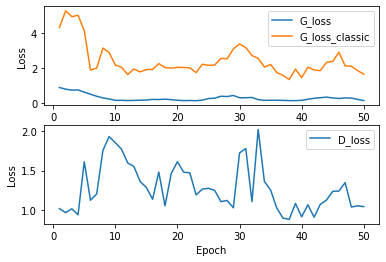

In [ ]:
def get_device():
  return 'cuda' if torch.cuda.is_available() else 'cpu'
  # return 'cpu'

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

device = get_device()
set_seed(33)

def main():
  G = G = Generator().to(device)
  D = Discriminator().to(device)

  G.apply(layer_init)
  D.apply(layer_init)

  g_optim = optim.Adam(G.parameters(), lr=0.0025, betas=(0.5, 0.999))
  g_optim_classic = optim.Adam(G.parameters(), lr=0.0025, betas=(0.5, 0.999))
  d_optim = optim.Adam(D.parameters(), lr=0.00001, betas=(0.5, 0.999))

  G_loss, G_loss_classic, D_loss = [], [], [] # for plotting
  train(G, D, g_optim, g_optim_classic, d_optim, device, G_loss, G_loss_classic, D_loss)

  plt.figure()
  plt.subplot(211)
  plt.plot(list(range(1, n_epoch+1)), G_loss, label = 'G_loss')
  plt.plot(list(range(1, n_epoch+1)), G_loss_classic, label = 'G_loss_classic')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.subplot(212)
  plt.plot(list(range(1, n_epoch+1)), D_loss, label = 'D_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  # sample(G, D, 1, device)


if __name__ == '__main__':
  main()